# Importing libraries

Initially, the project will require tensorflow and numpy to get started. Tensorflow will be used to load the dataset
and preprocess the image to fit into a numpy array. We will convert the image into a numpy array to make it memory efficient 
and to make the processing faster.

In [1]:
import tensorflow as tf
import numpy as np

In [ ]:
tf.__version__

'2.6.0'

# Loading the Dataset

In [ ]:
!wget https://www.dropbox.com/s/o3t9lfelgtgmdkw/Day%202%20-%20Mask%20Detection.zip
!unzip "Day 2 - Mask Detection.zip"
!rm "Day 2 - Mask Detection.zip"

The dataset has two directories where images for each class are saved. The idea is to bring both the classes into the  program with their respective images. And save them as training and validation data using the image_dataset_from_directory() of keras.preprocessing.

In [ ]:
width = 224
height = 224
#height and width are (224,224) since we will use the mobileNetv2 network
batch_size = 32
data_dir = "/content/dataset"
# /content/dataset

In [ ]:
training = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset='training',
    seed=123,
    image_size=(height, width),
    batch_size=batch_size
)

Found 3692 files belonging to 2 classes.
Using 2585 files for training.


In [ ]:
validation = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset='validation',
    seed=123,
    image_size=(height, width),
    batch_size=batch_size
)

Found 3692 files belonging to 2 classes.
Using 1107 files for validation.


In [ ]:
classes = training.class_names
classes

['with_mask', 'without_mask']

In [ ]:
training

<BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

# Visualizing images from the data set

After loading the dataset, the best way to verify the progress is by loading the dataset into an image using matplotlib. And using the corresponding labels with the images.

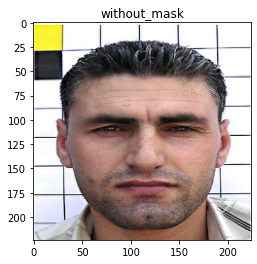

In [ ]:
import matplotlib.pyplot as plt
for images, labels in training.take(1):
    plt.imshow(images[1].numpy().astype('uint8'))
    plt.title(classes[labels[1]])

# Loading the MobileNetv2 model 

The MobileNetv2 model is a pretrained model that can be used for object detection. We can load the network using the keras.application
You can more  details about the mobilenetv2 network here - <a href= 'https://keras.io/api/applications/mobilenet/'> Link</a>

In [ ]:
from tensorflow.keras.applications import MobileNetV2

In [ ]:
model = MobileNetV2(weights='imagenet')

14548992/14536120 [==============================] - 0s 0us/step


# Compiling the model

After modeling the mobilenetv2 architecture, the compilation process starts where the we are using the adam optimizer and SparCategoricalCrossentropy as loss. Whereas, metrics is accuracy. 

In [ ]:
model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

# Training the model

In [ ]:
face_mask_detection = model.fit(training,validation_data=validation,epochs=3)

Epoch 1/3


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


81/81 [==============================] - 72s 429ms/step - loss: 0.2536 - accuracy: 0.9559 - val_loss: 2.5891 - val_accuracy: 0.7516
Epoch 2/3
81/81 [==============================] - 33s 400ms/step - loss: 0.0297 - accuracy: 0.9907 - val_loss: 1.4098 - val_accuracy: 0.8573
Epoch 3/3
81/81 [==============================] - 33s 400ms/step - loss: 0.0130 - accuracy: 0.9973 - val_loss: 0.7595 - val_accuracy: 0.9142


# Predicting on a new unknown image

In [ ]:
#load the image
img = tf.keras.preprocessing.image.load_img('face.jpg', target_size=(height, width))
#convert to array
image_array = tf.keras.preprocessing.image.img_to_array(img)
#expand dimensions to fit in the model
image_array = tf.expand_dims(image_array,0)
#check the shape of the image
image_array.shape

TensorShape([1, 224, 224, 3])

In [ ]:
predictions = model.predict(image_array)
#using softmax to get the results
score = tf.nn.softmax(predictions[0])

In [ ]:
import numpy
print(classes[numpy.argmax(score)])

without_mask


In [ ]:
#load the image
img = tf.keras.preprocessing.image.load_img('/content/dataset/without_mask/0_0_aidai_0084.jpg', target_size=(height, width))
#convert to array
image_array = tf.keras.preprocessing.image.img_to_array(img)
#expand dimensions to fit in the model
image_array = tf.expand_dims(image_array,0)

predictions = model.predict(image_array)
#using softmax to get the results
score = tf.nn.softmax(predictions[0])

print(classes[numpy.argmax(score)])

without_mask


In [ ]:
#load the image
img = tf.keras.preprocessing.image.load_img('/content/dataset/with_mask/0_0_0 copy 17.jpg', target_size=(height, width))
#convert to array
image_array = tf.keras.preprocessing.image.img_to_array(img)
#expand dimensions to fit in the model
image_array = tf.expand_dims(image_array,0)

predictions = model.predict(image_array)
#using softmax to get the results
score = tf.nn.softmax(predictions[0])

print(classes[numpy.argmax(score)])

with_mask


# Save the model

After we have created a classifier, we can save it for later use. 

In [ ]:
model.save('dummy.model', save_format="h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# Evaluation

It is necessary to evaluate the model before we move to the next stage. The evaluation will give us insights about two things:
1. Accuracy
2. If there is any anomaly in the model - Underfitting or Overfitting.

In any case, we must follow a different approach to train the model to get the best results. This can include, image augmentation and choosing our own layers and placing them over the MobileNetv2 network.

<h3> How to Improve the Model?</h3>

Sometimes, the accuracy of the model isn't what we have anticipated. So, there are a certain practices that can be followed to 
improve the performance of the model in order to get efficiency while working with the new data.

The following are some of the practices that may improve the model's performance:
1. Add more training data
2. Data Augmentation can help increase the number of training samples.
3. There might be a chance of overfitting the model with increased number of samples, in that case you can try a different model or include a head over the base model with custom layers. 